In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [110]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [111]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


/var/folders/8z/fnblqgd55213h_1ltnz5z4xh0000gn/T/ipykernel_24599/2038653828.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


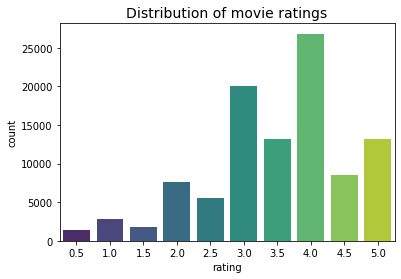

In [112]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [113]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [114]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

In [115]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [116]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [117]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the Bayesian Average, which in this case, is a blend of the overall average (our prior) and the movie's average. 

#### Bayesian Average
[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By definition, C represents the typical data set size. Let's make $C$ be the average number of ratings for a given movie. If the movie has the same number of ratings as an an average movie (around 10), the average is a 50-50 blend. So low rated movies are bumped up and high rated movies are bumped down, and this blending is adjusted as the sample size and credibility increase.

In [118]:
# note these are explicit ratings. some people say implicit ratings (e.g. minutes watched) has less bias
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head(53)

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
6,102,3.946078
7,54,3.185185
8,8,2.875000
9,16,3.125000


In [119]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings: pd.Series) -> float:
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [120]:
# let's test out our Bayesian average on Lamerica, which had two ratings of 5 stars. 
# The average should come down a lot towards our prior assumption (the pop avg)
lamerica = pd.Series([5, 5]) 
bayesian_avg(lamerica) # takes a pd.Series() as input

3.543

In [121]:
#Let's now apply bayesian_avg to all movies in our dataset.
# Our bayesian function takes in a pandas data series and returns a float or int, just like mean and count
 # reset_index() in this new table does just that. it resets the tables index after groupby results scrambled them
# the index in the table is a row identifier.

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg'] # we want to call our new column "bayesian_avg", not "rating" now
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [122]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [123]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']]) # inner join on movieId, bringing over title, but not including genre
movie_stats.sort_values('bayesian_avg', ascending=False).head()

# notice that lamerica is no longer at the top... Bayesian average brought it down because it only had 2 samples/reviews

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [124]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [125]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [126]:
# movie dataset cleaning (clean up string)
movies['genres'] = movies['genres'].apply(lambda x: x.split("|")) # similar to .map(), but can't apply function to entire rows/cols of a dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [127]:
# how many genres?
from collections import Counter

# the parentheses play two roles, for both the Counter object and the generator comprehension
genre_frequency = Counter(g for genres in movies['genres'] for g in genres) # Counter is a "+= 1" defaultDict(int) kind of object
print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [128]:
# note: the most_common() method of Counter must do some sorting of the values in the key-value pairs
# sortedDict maintains a sorted order on the keys, which isn't always helpful if you are interested in the values
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


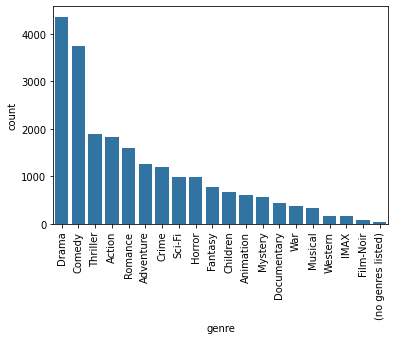

In [129]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Step 4: Data Pre-processing
    
We are going to use a technique called collaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix, because it captures the utility each user (row) places on each object (column). 

The beauty of collaborative filtering is that it doesn't require any information about the users or the movies to generate recommendations.


In [131]:
# Note: most movies won't be rated by a user, so it makes sense to have a sparse representation of our utility matrix
# we'll use a Compressed Sparse Representation matrix from scipy

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique() # rows
    N = df['movieId'].nunique() # cols

    # user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    # movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_mapper = {val: i for i, val in enumerate(np.unique(df["userId"]))}
    user_inv_mapper = {i: val for i, val in enumerate(np.unique(df["userId"]))}

    movie_mapper = {val: i for i, val in enumerate(np.unique(df["movieId"]))}
    movie_inv_mapper = {i: val for i, val in enumerate(np.unique(df["movieId"]))}
    
    # user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    # movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    # missing_users = set(df['userId']) - set(user_mapper.values())
    # missing_movies = set(df['movieId']) - set(movie_mapper.values())
    # print("Missing users:", missing_users)
    # print("Missing movies:", missing_movies)

    # for i, val in enumerate(np.unique(df["userId"])):
    #     if val not in user_mapper:
    #         print(f"User ID {val} not found in user_mapper")
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # a Compressed Sparse Representation the x, y pairs
    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


In [134]:
# users by movies
print(type(X), dir(X))
X.shape

<class 'scipy.sparse.csr.csr_matrix'> ['__abs__', '__add__', '__array_priority__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__lt__', '__matmul__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__pow__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmatmul__', '__rmul__', '__round__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_add_dense', '_add_sparse', '_arg_min_or_max', '_arg_min_or_max_axis', '_asindices', '_binopt', '_cs_matrix__get_has_canonical_format', '_cs_matrix__get_sorted', '_cs_matrix__set_has_canonical_format', '_cs_matrix__set_sorted', '_deduped

(610, 9724)

In [167]:
# how does CSR matrix compare in size
# https://nedbatchelder.com/blog/202002/sysgetsizeof_is_not_what_you_want.html
import sys

non_sparse = [[f"a string that isn't an int {i, j}" for i in range(len(np.unique(ratings["movieId"])))] for j in range(len(np.unique(ratings["userId"])))]
print(len(non_sparse), len(non_sparse[0]))
non_sparse_numpy_matrix = np.zeros((len(non_sparse), len(non_sparse[0])))
print(non_sparse_numpy_matrix.shape)

def get_size(obj, seen=None):
    """Recursively find the total size of an object and its members"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, (list, tuple, set, frozenset)):
        for item in obj:
            size += get_size(item, seen)
    elif isinstance(obj, dict):
        for key, value in obj.items():
            size += get_size(key, seen)
            size += get_size(value, seen)
    elif isinstance(obj, csr_matrix):
        size += obj.data.nbytes  # size of data array
        size += obj.indptr.nbytes  # size of indptr array
        size += obj.indices.nbytes  # size of indices array
    return size

print(f"{sys.getsizeof(X):,}", "bytes (for CSR)")
print(f"{get_size(X):,}", "bytes (for CSR with underlying object sizes added too)")
print(f"{sys.getsizeof(non_sparse):,}", "bytes (for nested list)")
print(f"{get_size(non_sparse):,}", "bytes (for nested list with underlying objects)")
print(f"{sys.getsizeof(non_sparse_numpy_matrix):,}", "bytes (numpy matrix according to getsizeof() looks to include everything)")
print(f"{non_sparse_numpy_matrix.nbytes:,}" "bytes (numpy matrix according to numpy)")
print(f"{get_size(non_sparse_numpy_matrix):,}", "bytes (numpy matrix according to custom function)")


610 9724
(610, 9724)
48 bytes (for CSR)
1,212,524 bytes (for CSR with underlying object sizes added too)
5,432 bytes (for nested list)
566,268,732 bytes (for nested list with underlying objects)
47,453,248 bytes (numpy matrix according to getsizeof() looks to include everything)
47,453,120bytes (numpy matrix according to numpy)
47,453,248 bytes (numpy matrix according to custom function)
